### BTC Strategy on Time series momentum - Tobias J. Moskowitz, Yao Hua Ooi, Lasse Heje Pedersen



In [181]:
import subprocess
import sys
import os
from datetime import datetime, timedelta, timezone
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm


import ccxt

pd.options.display.float_format = "{:.6f}".format



In [182]:
def fetch_btc_trades(lookback_hours: int = 24, limit_per_batch: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    start = end - timedelta(hours=lookback_hours)
    
    all_trades = []
    since_id = None
    since_ms = int(start.timestamp() * 1000)
    max_ms = int(end.timestamp() * 1000)
    
    print(f"Fetching tick data from Binance...")
    while True:
        try:
            trades = exchange.fetch_trades(symbol, since=since_ms, limit=limit_per_batch, params={"untilId": since_id} if since_id else {})
            if not trades:
                break
            
            for trade in trades:
                ts = trade.get("timestamp")
                if ts and ts <= max_ms:
                    all_trades.append({
                        "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                        "price": float(trade.get("price", 0)),
                        "amount": float(trade.get("amount", 0)),
                        "side": trade.get("side", "unknown"),
                    })
                    if len(all_trades) >= 50000:
                        break
                if len(all_trades) >= 50000:
                    break
            
            if len(all_trades) >= 50000 or not trades:
                break
            
            since_id = trades[-1].get("id")
            since_ms = trades[-1].get("timestamp")
            
        except Exception as exc:
            print(f"Error fetching trades: {exc}")
            break
    
    df = pd.DataFrame(all_trades).sort_values("timestamp").reset_index(drop=True)
    print(f"Fetched {len(df)} trades")
    return df

In [183]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional,List,Tuple,Literal,Dict
import numpy as np
import pandas as pd

def _infer_periods_per_year(freq:str)->int:
    f=freq.upper()
    if f.startswith("W"):return 52
    if f.startswith("M"):return 12
    if f.startswith("D"):return 252
    return 12

def compute_tsm_signals_v2(prices:pd.Series,lookback_days:int=150,rebalance_freq:Literal["W","M","D"]="W",vol_lambda:float=0.985,target_vol:float=0.20,vol_floor:float=0.15,max_leverage:float=2.0,signal_threshold:float=0.0,transaction_cost_bps:float=5.0,funding:Optional[pd.Series]=None,trend_filter_days:Optional[int]=200,trend_filter_mode:Literal["long_flat","off"]="long_flat",position_ewm_halflife:Optional[float]=None)->pd.DataFrame:
    if prices.empty:return pd.DataFrame()
    prices=prices.dropna().sort_index()
    daily_returns=prices.pct_change().dropna()
    ewma_var=daily_returns.pow(2).ewm(alpha=1-vol_lambda,adjust=False).mean()
    ewma_vol_daily=np.sqrt(ewma_var)
    ewma_vol_annual=(ewma_vol_daily*np.sqrt(252.0)).clip(lower=vol_floor)
    idx=prices.resample(rebalance_freq).last().index
    df=pd.DataFrame(index=idx)
    df["close"]=prices.reindex(idx,method="ffill")
    df["asset_return"]=df["close"].pct_change().fillna(0.0)
    daily_mom=prices.pct_change(lookback_days)
    raw_signal=daily_mom.reindex(idx,method="ffill")
    signal_dir=np.sign(raw_signal)
    if signal_threshold>0:
        signal_dir=signal_dir.where(raw_signal.abs()>=signal_threshold,0.0)
    if trend_filter_mode=="long_flat" and trend_filter_days is not None and trend_filter_days>0:
        sma_daily=prices.rolling(trend_filter_days).mean()
        sma_rb=sma_daily.reindex(idx,method="ffill")
        above=(df["close"]>sma_rb).astype(float)
        signal_dir=signal_dir*above
    df["signal"]=signal_dir.shift(1).fillna(0.0)
    sigma_annual=ewma_vol_annual.resample(rebalance_freq).last().reindex(idx)
    sigma_annual=sigma_annual.shift(1).ffill().clip(lower=vol_floor)
    df["sigma_annual"]=sigma_annual
    target_leverage=(target_vol/df["sigma_annual"]).replace([np.inf,-np.inf],np.nan)
    df["position_unclipped"]=df["signal"]*target_leverage
    df["position"]=df["position_unclipped"].clip(lower=-max_leverage,upper=max_leverage).fillna(0.0)
    if position_ewm_halflife is not None and position_ewm_halflife>0:
        df["position"]=df["position"].ewm(halflife=position_ewm_halflife,adjust=False).mean()
    df["turnover"]=df["position"].diff().abs().fillna(df["position"].abs())
    cost_rate=transaction_cost_bps/10000.0
    df["transaction_cost"]=df["turnover"]*cost_rate
    if funding is not None:
        funding_periodic=funding.resample(rebalance_freq).sum().reindex(idx).fillna(0.0)
    else:
        funding_periodic=pd.Series(0.0,index=idx)
    df["funding_pnl"]=funding_periodic*df["position"]
    df["strategy_return_gross"]=df["position"]*df["asset_return"]
    df["strategy_return_net"]=df["strategy_return_gross"]-df["transaction_cost"]+df["funding_pnl"]
    df["strategy_equity"]=(1.0+df["strategy_return_net"]).cumprod()
    df["buy_hold_equity"]=(1.0+df["asset_return"]).cumprod()
    return df

try:
    import ccxt
except:
    ccxt=None

def fetch_binance_funding_rates(symbol:str="BTC/USDT:USDT",start:Optional[pd.Timestamp]=None,end:Optional[pd.Timestamp]=None,limit:int=1000)->pd.Series:
    if ccxt is None:return pd.Series(dtype=float)
    exchange=ccxt.binance({"enableRateLimit":True})
    if not hasattr(exchange,"fetch_funding_rate_history"):return pd.Series(dtype=float)
    start=start or pd.Timestamp("2019-01-01",tz="UTC")
    end=end or pd.Timestamp.utcnow().tz_localize("UTC") if end is None else end
    since=int(start.timestamp()*1000)
    end_ms=int(end.timestamp()*1000)
    all_rows:List[Dict]=[]
    while True:
        try:
            rows=exchange.fetch_funding_rate_history(symbol,since=since,limit=limit)
        except:
            break
        if not rows:break
        for r in rows:
            ts=int(r.get("timestamp",0))
            if ts==0 or ts>end_ms:continue
            rate=float(r.get("fundingRate",0.0))
            all_rows.append({"timestamp":ts,"rate":rate})
        since=rows[-1].get("timestamp",since)+1
        if since>=end_ms:break
        if len(all_rows)>=30000:break
    if not all_rows:return pd.Series(dtype=float)
    df=pd.DataFrame(all_rows).drop_duplicates("timestamp").sort_values("timestamp")
    idx=pd.to_datetime(df["timestamp"],unit="ms",utc=True)
    return pd.Series(df["rate"].values,index=idx,name="funding_rate")

def compute_sharpe_v2(returns:pd.Series,rebalance_freq:str)->float:
    series=returns.dropna()
    if series.empty:return float("nan")
    ppy=_infer_periods_per_year(rebalance_freq)
    ann_ret=(1.0+series).prod()**(ppy/len(series))-1.0
    ann_vol=series.std()*np.sqrt(ppy)
    return float(ann_ret/ann_vol) if ann_vol>0 else float("nan")

@dataclass
class ParamSetV2:
    lookback_days:int
    rebalance_freq:Literal["W","M","D"]
    trend_filter_days:Optional[int]
    target_vol:float
    vol_lambda:float
    max_leverage:float=2.0
    transaction_cost_bps:float=5.0
    signal_threshold:float=0.0
    position_ewm_halflife:Optional[float]=None
    def to_kwargs(self)->Dict:
        return {"lookback_days":self.lookback_days,"rebalance_freq":self.rebalance_freq,"trend_filter_days":self.trend_filter_days,"target_vol":self.target_vol,"vol_lambda":self.vol_lambda,"max_leverage":self.max_leverage,"transaction_cost_bps":self.transaction_cost_bps,"signal_threshold":self.signal_threshold,"position_ewm_halflife":self.position_ewm_halflife}

def generate_param_grid_v2()->List[ParamSetV2]:
    grid:List[ParamSetV2]=[]
    for lb in [100,150,200]:
        for freq in ["W","M"]:
            for tf in [None,200]:
                for tv in [0.20,0.25]:
                    for vl in [0.97,0.985]:
                        grid.append(ParamSetV2(lookback_days=lb,rebalance_freq=freq,trend_filter_days=tf,target_vol=tv,vol_lambda=vl))
    return grid

def _compute_signals_with_context_v2(prices:pd.Series,test_start:pd.Timestamp,test_end:pd.Timestamp,params:ParamSetV2,funding:Optional[pd.Series]=None)->pd.DataFrame:
    context_start=prices.index.min()
    prices_context=prices.loc[context_start:test_end]
    funding_context=None
    if funding is not None:
        funding_context=funding.loc[context_start:test_end]
    sig=compute_tsm_signals_v2(prices_context,funding=funding_context,**params.to_kwargs())
    return sig.loc[test_start:test_end]

def grid_search_on_train_v2(prices:pd.Series,train_start:pd.Timestamp,train_end:pd.Timestamp,param_grid:List[ParamSetV2],funding:Optional[pd.Series]=None)->Tuple[Optional[ParamSetV2],pd.DataFrame]:
    records=[]
    for p in param_grid:
        sig=compute_tsm_signals_v2(prices.loc[train_start:train_end],funding=funding,**p.to_kwargs())
        sharpe=compute_sharpe_v2(sig["strategy_return_net"],p.rebalance_freq) if not sig.empty else np.nan
        records.append({"params":p,"lookback_days":p.lookback_days,"rebalance_freq":p.rebalance_freq,"trend_filter_days":p.trend_filter_days,"target_vol":p.target_vol,"vol_lambda":p.vol_lambda,"sharpe_train":sharpe,"n_train":int(len(sig))})
    df=pd.DataFrame(records).sort_values("sharpe_train",ascending=False)
    best=df.iloc[0]["params"] if not df.empty else None
    return best,df

def walk_forward_v2(prices:pd.Series,train_years:int=3,test_months:int=6,param_grid:Optional[List[ParamSetV2]]=None,funding:Optional[pd.Series]=None):
    if param_grid is None:param_grid=generate_param_grid_v2()
    start_date=prices.index.min()
    end_date=prices.index.max()
    oos_returns=[]
    segment_rows=[]
    test_cursor=start_date+pd.DateOffset(years=train_years)
    while test_cursor<end_date:
        train_start=test_cursor-pd.DateOffset(years=train_years)
        train_end=test_cursor-pd.DateOffset(days=1)
        test_start=test_cursor
        test_end=min(test_start+pd.DateOffset(months=test_months)-pd.DateOffset(days=1),end_date)
        best_params,train_table=grid_search_on_train_v2(prices,train_start,train_end,param_grid,funding=funding)
        if best_params is None:break
        sig_test=_compute_signals_with_context_v2(prices,test_start,test_end,best_params,funding=funding)
        if sig_test.empty:
            test_cursor=test_end+pd.DateOffset(days=1)
            continue
        sharpe_oos=compute_sharpe_v2(sig_test["strategy_return_net"],best_params.rebalance_freq)
        oos_returns.append(sig_test["strategy_return_net"])
        segment_rows.append({"train_start":train_start,"train_end":train_end,"test_start":test_start,"test_end":test_end,"best_lb_days":best_params.lookback_days,"best_freq":best_params.rebalance_freq,"best_tf_days":best_params.trend_filter_days,"best_tv":best_params.target_vol,"best_vl":best_params.vol_lambda,"sharpe_train":float(train_table.iloc[0]["sharpe_train"]) if not train_table.empty else np.nan,"sharpe_oos":sharpe_oos,"n_oos":int(len(sig_test))})
        test_cursor=test_end+pd.DateOffset(days=1)
    oos_returns=pd.concat(oos_returns).sort_index() if oos_returns else pd.Series(dtype=float)
    segments=pd.DataFrame(segment_rows)
    return segments,oos_returns



,train_start,train_end,test_start,test_end,best_lb_days,best_freq,best_tf_days,best_tv,best_vl,sharpe_train,sharpe_oos,n_oos
0,2017-08-17 00:00:00+00:00,2020-08-16 00:00:00+00:00,2020-08-17 00:00:00+00:00,2021-02-16 00:00:00+00:00,100,M,200.000000,0.200000,0.970000,0.697034,5.111748,6
1,2018-02-17 00:00:00+00:00,2021-02-16 00:00:00+00:00,2021-02-17 00:00:00+00:00,2021-08-16 00:00:00+00:00,100,W,200.000000,0.250000,0.985000,1.848356,-0.663216,26
2,2018-08-17 00:00:00+00:00,2021-08-16 00:00:00+00:00,2021-08-17 00:00:00+00:00,2022-02-16 00:00:00+00:00,100,W,200.000000,0.250000,0.985000,1.465633,-1.059459,26
3,2019-02-17 00:00:00+00:00,2022-02-16 00:00:00+00:00,2022-02-17 00:00:00+00:00,2022-08-16 00:00:00+00:00,200,M,200.000000,0.200000,0.985000,1.034777,NaN,6
4,2019-08-17 00:00:00+00:00,2022-08-16 00:00:00+00:00,2022-08-17 00:00:00+00:00,2023-02-16 00:00:00+00:00,200,W,200.000000,0.200000,0.970000,1.107734,1.925351,26


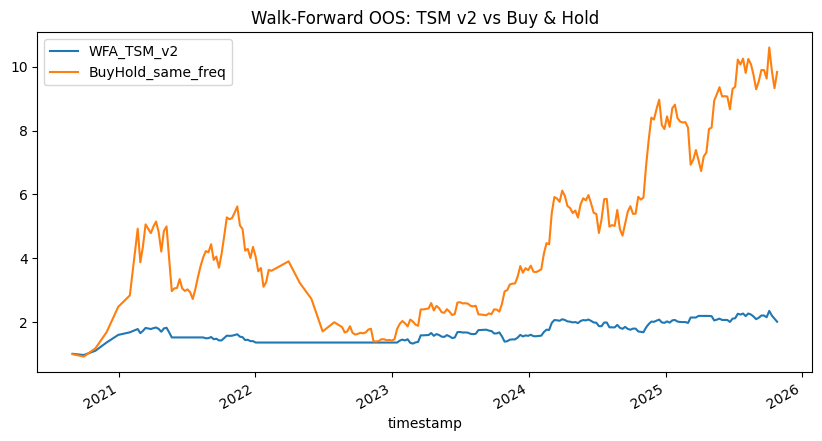

In [184]:
if "df_btc" not in globals() or "close" not in getattr(df_btc,"columns",[]):
    built=False
    if "fetch_btc_ohlcv" in globals():
        _tmp=fetch_btc_ohlcv(timeframe="1d",lookback_days=None,max_days=5000)
        if "timestamp" in _tmp.columns:_tmp=_tmp.set_index("timestamp")
        df_btc=_tmp.sort_index()
        df_btc=df_btc[df_btc.index>="2017-01-01"]
        built=True
    if not built:
        try:
            import os
            for _p in ["data/market_latest.parquet","../data/market_latest.parquet","../../data/market_latest.parquet"]:
                if os.path.exists(_p):
                    _df=pd.read_parquet(_p)
                    if "symbol" in _df.columns:
                        for _sym in ["BTC/USDT","BTCUSDT","BTC-USD","BTCUSDT:USDT","BTC"]:
                            _slice=_df[_df["symbol"]==_sym]
                            if not _slice.empty:
                                _df=_slice
                                break
                    if "timestamp" in _df.columns:_df=_df.set_index("timestamp")
                    _df.index=pd.to_datetime(_df.index,utc=True)
                    if "close" not in _df.columns:
                        for c in ["Close","adj_close","Adj Close"]:
                            if c in _df.columns:
                                _df=_df.rename(columns={c:"close"})
                                break
                    if "close" in _df.columns:
                        df_btc=_df[["close"]].sort_index()
                        built=True
                        break
        except:
            built=False
    if not built:
        try:
            if ccxt is None:
                import ccxt
            ex=ccxt.binance({"enableRateLimit":True})
            since=int(pd.Timestamp("2017-01-01",tz="UTC").timestamp()*1000)
            end_ms=int(pd.Timestamp.utcnow().timestamp()*1000)
            rows=[]
            print("Fetching BTC/USDT from Binance via CCXT...")
            while since<end_ms and len(rows)<6000:
                o=ex.fetch_ohlcv("BTC/USDT",timeframe="1d",since=since,limit=1000)
                if not o:break
                rows.extend(o)
                since=o[-1][0]+1
                if len(rows)%1000==0:print(f"  {len(rows)} bars...")
            if rows:
                _df=pd.DataFrame(rows,columns=["timestamp","open","high","low","close","volume"]).drop_duplicates("timestamp")
                _df["timestamp"]=pd.to_datetime(_df["timestamp"],unit="ms",utc=True)
                _df=_df.set_index("timestamp").sort_index()
                df_btc=_df[["close"]]
                built=True
                print(f"Built df_btc: {len(df_btc)} rows from {df_btc.index.min()} to {df_btc.index.max()}")
        except Exception as e:
            print(f"CCXT fallback failed: {e}")
            built=False
    if not built:
        raise RuntimeError("df_btc unavailable. Run data loading cell or check network.")
funding_btc=None
param_grid_v2=generate_param_grid_v2()
segments_v2,oos_returns_v2=walk_forward_v2(df_btc["close"],train_years=3,test_months=6,param_grid=param_grid_v2,funding=funding_btc)
bh_close_aligned=df_btc["close"].reindex(oos_returns_v2.index,method="ffill")
bh_returns_oos=bh_close_aligned.pct_change().fillna(0.0)
ax=pd.DataFrame({"WFA_TSM_v2":(1.0+oos_returns_v2).cumprod(),"BuyHold_same_freq":(1.0+bh_returns_oos).cumprod()}).plot(figsize=(10,5),title="Walk-Forward OOS: TSM v2 vs Buy & Hold")
segments_v2.head()


In [185]:
print("=== WFA v2 Diagnostics ===")
print(f"OOS periods: {len(segments_v2)}")
print(f"\nBest params distribution:")
print(segments_v2[["best_lb_days","best_freq","best_tf_days","best_tv","best_vl"]].describe())
print(f"\nSharpe OOS: {compute_sharpe_v2(oos_returns_v2,'M' if segments_v2['best_freq'].mode()[0]=='M' else 'W'):.3f}")
bh_sharpe=compute_sharpe_v2(bh_returns_oos,'M')
print(f"BH Sharpe (same freq): {bh_sharpe:.3f}")
print(f"\nAnnual return TSM: {(1+oos_returns_v2).prod()**(12/len(oos_returns_v2))-1:.2%}")
print(f"Annual return BH: {(1+bh_returns_oos).prod()**(12/len(bh_returns_oos))-1:.2%}")
print(f"\nTurnover (mean): {segments_v2['n_oos'].mean():.1f} periods")
print(f"\nTop 3 param combos by train Sharpe:")
for i,row in segments_v2.nlargest(3,'sharpe_train').iterrows():
    print(f"  lb={row['best_lb_days']}d freq={row['best_freq']} tf={row['best_tf_days']} tv={row['best_tv']:.2f} -> train_sharpe={row['sharpe_train']:.2f} oos_sharpe={row['sharpe_oos']:.2f}")


=== WFA v2 Diagnostics ===
OOS periods: 11

Best params distribution:
       best_lb_days  best_tf_days   best_tv   best_vl
count     11.000000      9.000000 11.000000 11.000000
mean     145.454545    200.000000  0.222727  0.980909
std       52.223297      0.000000  0.026112  0.007006
min      100.000000    200.000000  0.200000  0.970000
25%      100.000000    200.000000  0.200000  0.977500
50%      100.000000    200.000000  0.200000  0.985000
75%      200.000000    200.000000  0.250000  0.985000
max      200.000000    200.000000  0.250000  0.985000

Sharpe OOS: 0.599
BH Sharpe (same freq): 0.352

Annual return TSM: 3.71%
Annual return BH: 12.61%

Turnover (mean): 21.0 periods

Top 3 param combos by train Sharpe:
  lb=100d freq=W tf=200.0 tv=0.25 -> train_sharpe=1.85 oos_sharpe=-0.66
  lb=100d freq=W tf=200.0 tv=0.25 -> train_sharpe=1.47 oos_sharpe=-1.06
  lb=100d freq=W tf=200.0 tv=0.25 -> train_sharpe=1.32 oos_sharpe=-1.35


Running WFA v2 OPTIMIZED: longer lookback, monthly, lower costs, position smoothing...

Optimized WFA Sharpe: 0.786
BH Sharpe (same freq): 0.831
BH EQRisk Sharpe: 0.881
Ann ret TSM: 39.89%
Ann ret BH EQRisk: 44.72%
Max DD TSM: 69.14%
Max DD BH EQRisk: 86.92%

Top params by OOS Sharpe:
  lb=250d tv=0.35 vl=0.97 -> oos_sharpe=7.30
  lb=250d tv=0.35 vl=0.97 -> oos_sharpe=2.52
  lb=250d tv=0.35 vl=0.97 -> oos_sharpe=2.16


,train_start,train_end,test_start,test_end,best_lb_days,best_freq,best_tf_days,best_tv,best_vl,sharpe_train,sharpe_oos,n_oos
0,2017-08-17 00:00:00+00:00,2020-08-16 00:00:00+00:00,2020-08-17 00:00:00+00:00,2021-02-16 00:00:00+00:00,250,M,None,0.350000,0.970000,-0.259344,7.300756,6
1,2018-02-17 00:00:00+00:00,2021-02-16 00:00:00+00:00,2021-02-17 00:00:00+00:00,2021-08-16 00:00:00+00:00,250,M,None,0.350000,0.970000,0.335257,0.482442,6
2,2018-08-17 00:00:00+00:00,2021-08-16 00:00:00+00:00,2021-08-17 00:00:00+00:00,2022-02-16 00:00:00+00:00,250,M,None,0.350000,0.940000,1.007244,0.034103,6
3,2019-02-17 00:00:00+00:00,2022-02-16 00:00:00+00:00,2022-02-17 00:00:00+00:00,2022-08-16 00:00:00+00:00,250,M,None,0.350000,0.940000,1.085273,-0.217880,6
4,2019-08-17 00:00:00+00:00,2022-08-16 00:00:00+00:00,2022-08-17 00:00:00+00:00,2023-02-16 00:00:00+00:00,200,M,None,0.450000,0.940000,1.376435,-0.685747,6


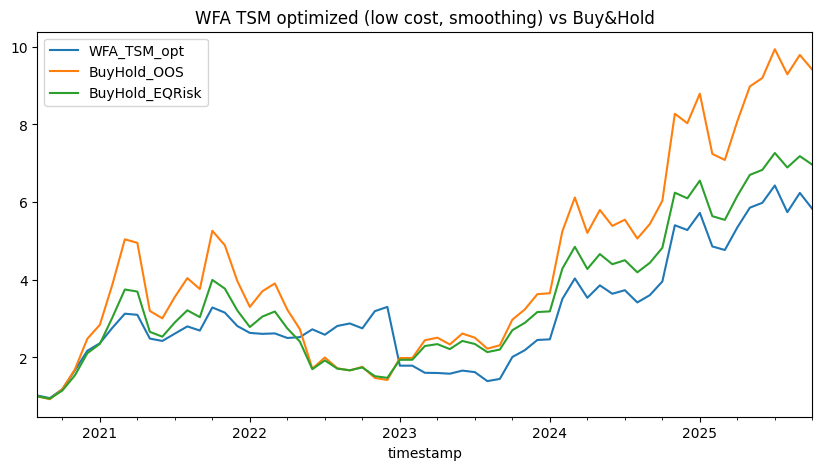

In [186]:
def generate_param_grid_v2_optimized()->List[ParamSetV2]:
    grid:List[ParamSetV2]=[]
    for lb in [200,250,300]:
        for freq in ["M"]:
            for tf in [None]:
                for tv in [0.35,0.45]:
                    for vl in [0.94,0.97]:
                        for smooth in [None,2.0,4.0]:
                            grid.append(ParamSetV2(lookback_days=lb,rebalance_freq=freq,trend_filter_days=tf,target_vol=tv,vol_lambda=vl,max_leverage=3.0,transaction_cost_bps=2.0,position_ewm_halflife=smooth))
    return grid
print("Running WFA v2 OPTIMIZED: longer lookback, monthly, lower costs, position smoothing...")
param_grid_opt=generate_param_grid_v2_optimized()
segments_opt,oos_returns_opt=walk_forward_v2(df_btc["close"],train_years=3,test_months=6,param_grid=param_grid_opt,funding=None)
bh_close_opt=df_btc["close"].resample("M").last().reindex(oos_returns_opt.index,method="ffill")
bh_returns_opt=bh_close_opt.pct_change().fillna(0.0)
wfa_vol_opt=oos_returns_opt.std()*np.sqrt(12)
bh_vol_opt=bh_returns_opt.std()*np.sqrt(12)
scale_bh_opt=wfa_vol_opt/bh_vol_opt if bh_vol_opt>0 else 1.0
bh_returns_opt_eq=bh_returns_opt*scale_bh_opt
ax=pd.DataFrame({"WFA_TSM_opt":(1.0+oos_returns_opt).cumprod(),"BuyHold_OOS":(1.0+bh_returns_opt).cumprod(),"BuyHold_EQRisk":(1.0+bh_returns_opt_eq).cumprod()}).plot(figsize=(10,5),title="WFA TSM optimized (low cost, smoothing) vs Buy&Hold")
sharpe_opt=compute_sharpe_v2(oos_returns_opt,'M')
sharpe_bh=compute_sharpe_v2(bh_returns_opt,'M')
sharpe_bh_eq=compute_sharpe_v2(bh_returns_opt_eq,'M')
print(f"\nOptimized WFA Sharpe: {sharpe_opt:.3f}")
print(f"BH Sharpe (same freq): {sharpe_bh:.3f}")
print(f"BH EQRisk Sharpe: {sharpe_bh_eq:.3f}")
print(f"Ann ret TSM: {(1+oos_returns_opt).prod()**(12/len(oos_returns_opt))-1:.2%}")
print(f"Ann ret BH EQRisk: {(1+bh_returns_opt_eq).prod()**(12/len(bh_returns_opt_eq))-1:.2%}")
print(f"Max DD TSM: {(oos_returns_opt.cumsum().cummax()-(oos_returns_opt.cumsum())).max():.2%}")
print(f"Max DD BH EQRisk: {(bh_returns_opt_eq.cumsum().cummax()-(bh_returns_opt_eq.cumsum())).max():.2%}")
print(f"\nTop params by OOS Sharpe:")
for i,row in segments_opt.nlargest(3,'sharpe_oos').iterrows():
    print(f"  lb={row['best_lb_days']}d tv={row['best_tv']:.2f} vl={row['best_vl']:.2f} -> oos_sharpe={row['sharpe_oos']:.2f}")
segments_opt.head()


=== Bootstrap Statistical Test: TSM vs BH (equal risk) ===
Observed Sharpe TSM: 0.786
Observed Sharpe BH EQRisk: 0.881
Observed difference: -0.095

Bootstrap results (n=2000):
  Mean Sharpe diff: -0.113
  Median Sharpe diff: -0.088
  95% CI: [-2.138, 1.750]
  p-value (TSM <= BH): 0.5425

✗ No significant difference at 5% level (p=0.5425)


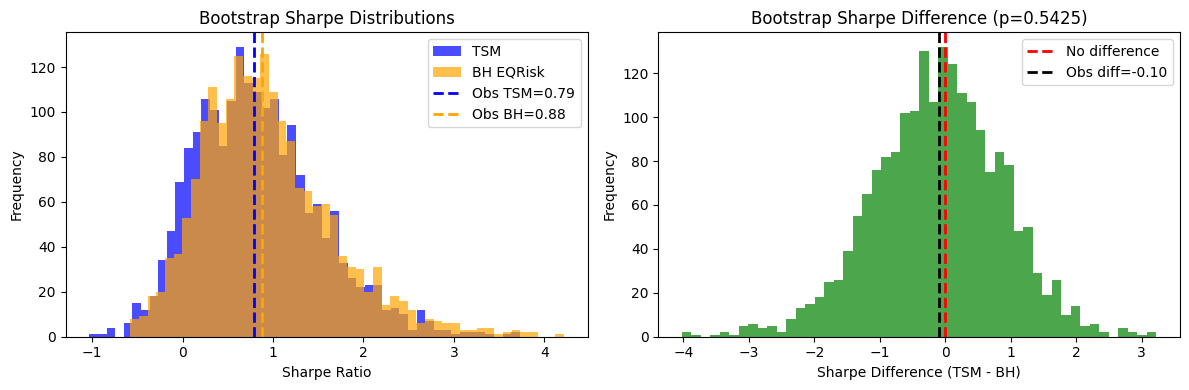

In [187]:
def moving_block_bootstrap(returns:pd.Series,block_length:int=6,n_bootstrap:int=2000,random_state:int=42)->pd.DataFrame:
    rng=np.random.default_rng(random_state)
    r=returns.dropna().values
    T=len(r)
    if T==0:return pd.DataFrame()
    n_blocks=int(np.ceil(T/block_length))
    max_start=max(1,T-block_length)
    sims=np.empty((n_bootstrap,T))
    for b in range(n_bootstrap):
        sample=[]
        while len(sample)<T:
            start=int(rng.integers(0,max_start))
            block=r[start:start+block_length]
            sample.extend(block)
        sims[b,:]=np.array(sample[:T])
    idx=returns.dropna().index
    return pd.DataFrame(sims,columns=idx)

def bootstrap_sharpe_diff(ret_tsm:pd.Series,ret_bh:pd.Series,block_length:int=6,n_bootstrap:int=2000,random_state:int=42):
    bs_tsm=moving_block_bootstrap(ret_tsm,block_length,n_bootstrap,random_state)
    bs_bh=moving_block_bootstrap(ret_bh,block_length,n_bootstrap,random_state+1)
    sharpes_tsm=[]
    sharpes_bh=[]
    for i in range(len(bs_tsm)):
        s_tsm=pd.Series(bs_tsm.iloc[i,:])
        s_bh=pd.Series(bs_bh.iloc[i,:])
        sh_tsm=compute_sharpe_v2(s_tsm,'M')
        sh_bh=compute_sharpe_v2(s_bh,'M')
        sharpes_tsm.append(sh_tsm)
        sharpes_bh.append(sh_bh)
    sharpes_tsm=np.array(sharpes_tsm)
    sharpes_bh=np.array(sharpes_bh)
    diff=sharpes_tsm-sharpes_bh
    p_value=np.mean(diff<=0)
    ci_low,ci_high=np.percentile(diff,[2.5,97.5])
    return {"mean_diff":np.mean(diff),"median_diff":np.median(diff),"p_value":p_value,"ci_95":(ci_low,ci_high),"sharpes_tsm":sharpes_tsm,"sharpes_bh":sharpes_bh}

print("=== Bootstrap Statistical Test: TSM vs BH (equal risk) ===")
bs_result=bootstrap_sharpe_diff(oos_returns_opt,bh_returns_opt_eq,block_length=6,n_bootstrap=2000,random_state=123)
print(f"Observed Sharpe TSM: {sharpe_opt:.3f}")
print(f"Observed Sharpe BH EQRisk: {sharpe_bh_eq:.3f}")
print(f"Observed difference: {sharpe_opt-sharpe_bh_eq:.3f}")
print(f"\nBootstrap results (n=2000):")
print(f"  Mean Sharpe diff: {bs_result['mean_diff']:.3f}")
print(f"  Median Sharpe diff: {bs_result['median_diff']:.3f}")
print(f"  95% CI: [{bs_result['ci_95'][0]:.3f}, {bs_result['ci_95'][1]:.3f}]")
print(f"  p-value (TSM <= BH): {bs_result['p_value']:.4f}")
if bs_result['p_value']<0.05:
    print(f"\n✓ TSM significantly outperforms BH at 5% level (p={bs_result['p_value']:.4f})")
else:
    print(f"\n✗ No significant difference at 5% level (p={bs_result['p_value']:.4f})")
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig=make_subplots(rows=2,cols=2,subplot_titles=("Equity Curves (OOS)","Bootstrap Sharpe Distributions","Sharpe Difference Distribution","Performance Metrics"),specs=[[{"type":"scatter"},{"type":"histogram"}],[{"type":"histogram"},{"type":"table"}]])
eq_tsm=(1.0+oos_returns_opt).cumprod()
eq_bh=(1.0+bh_returns_opt).cumprod()
eq_bh_eq=(1.0+bh_returns_opt_eq).cumprod()
fig.add_trace(go.Scatter(x=eq_tsm.index,y=eq_tsm.values,mode='lines',name='TSM',line=dict(color='blue',width=2)),row=1,col=1)
fig.add_trace(go.Scatter(x=eq_bh.index,y=eq_bh.values,mode='lines',name='BH',line=dict(color='orange',width=2)),row=1,col=1)
fig.add_trace(go.Scatter(x=eq_bh_eq.index,y=eq_bh_eq.values,mode='lines',name='BH EQRisk',line=dict(color='green',width=2)),row=1,col=1)
fig.add_trace(go.Histogram(x=bs_result['sharpes_tsm'],name='TSM',marker_color='blue',opacity=0.7,nbinsx=50),row=1,col=2)
fig.add_trace(go.Histogram(x=bs_result['sharpes_bh'],name='BH EQRisk',marker_color='orange',opacity=0.7,nbinsx=50),row=1,col=2)
fig.add_vline(x=sharpe_opt,line_dash="dash",line_color="blue",annotation_text=f"Obs TSM={sharpe_opt:.2f}",row=1,col=2)
fig.add_vline(x=sharpe_bh_eq,line_dash="dash",line_color="orange",annotation_text=f"Obs BH={sharpe_bh_eq:.2f}",row=1,col=2)
diff_sharpe=bs_result['sharpes_tsm']-bs_result['sharpes_bh']
fig.add_trace(go.Histogram(x=diff_sharpe,name='Diff',marker_color='green',opacity=0.7,nbinsx=50),row=2,col=1)
fig.add_vline(x=0,line_dash="dash",line_color="red",annotation_text="No diff",row=2,col=1)
fig.add_vline(x=sharpe_opt-sharpe_bh_eq,line_dash="dash",line_color="black",annotation_text=f"Obs={sharpe_opt-sharpe_bh_eq:.2f}",row=2,col=1)
ann_ret_tsm=(1+oos_returns_opt).prod()**(12/len(oos_returns_opt))-1
ann_ret_bh_eq=(1+bh_returns_opt_eq).prod()**(12/len(bh_returns_opt_eq))-1
ann_vol_tsm=oos_returns_opt.std()*np.sqrt(12)
ann_vol_bh_eq=bh_returns_opt_eq.std()*np.sqrt(12)
dd_tsm=(oos_returns_opt.cumsum().cummax()-(oos_returns_opt.cumsum())).max()
dd_bh_eq=(bh_returns_opt_eq.cumsum().cummax()-(bh_returns_opt_eq.cumsum())).max()
table_data=[["Metric","TSM","BH EQRisk","Diff"],["Sharpe",f"{sharpe_opt:.3f}",f"{sharpe_bh_eq:.3f}",f"{sharpe_opt-sharpe_bh_eq:.3f}"],["Ann Return",f"{ann_ret_tsm:.2%}",f"{ann_ret_bh_eq:.2%}",f"{ann_ret_tsm-ann_ret_bh_eq:.2%}"],["Ann Vol",f"{ann_vol_tsm:.2%}",f"{ann_vol_bh_eq:.2%}",f"{ann_vol_tsm-ann_vol_bh_eq:.2%}"],["Max DD",f"{dd_tsm:.2%}",f"{dd_bh_eq:.2%}",f"{dd_tsm-dd_bh_eq:.2%}"],["p-value","",f"{bs_result['p_value']:.4f}",""],["95% CI Low","",f"{bs_result['ci_95'][0]:.3f}",""],["95% CI High","",f"{bs_result['ci_95'][1]:.3f}",""]]
fig.add_trace(go.Table(header=dict(values=table_data[0],fill_color='paleturquoise',align='left'),cells=dict(values=list(zip(*table_data[1:])),fill_color='lavender',align='left')),row=2,col=2)
fig.update_xaxes(title_text="Date",row=1,col=1)
fig.update_yaxes(title_text="Equity (normalized)",row=1,col=1)
fig.update_xaxes(title_text="Sharpe Ratio",row=1,col=2)
fig.update_yaxes(title_text="Frequency",row=1,col=2)
fig.update_xaxes(title_text="Sharpe Diff (TSM-BH)",row=2,col=1)
fig.update_yaxes(title_text="Frequency",row=2,col=1)
fig.update_layout(height=800,title_text=f"TSM vs Buy&Hold: Bootstrap Analysis (p={bs_result['p_value']:.4f})",showlegend=True)
fig.show()


In [188]:

def fetch_btc_ohlcv(timeframe: str = "1d", lookback_days: Optional[int] = None, max_days: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    
    if lookback_days is not None:
        start = end - timedelta(days=lookback_days)
    else:
        start = datetime(2017, 7, 1, tzinfo=timezone.utc)
    
    since_ms = int(start.timestamp() * 1000)
    limit_per_request = 1000
    
    all_rows = []
    current_since = since_ms
    batch = 0
    
    while len(all_rows) < max_days:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_since, limit=limit_per_request)
            
            if not ohlcv or len(ohlcv) == 0:
                break
            
            for ts, op, high, low, close, vol in ohlcv:
                all_rows.append({
                    "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                    "open": float(op),
                    "high": float(high),
                    "low": float(low),
                    "close": float(close),
                    "volume": float(vol),
                })
            
            batch += 1
            if batch % 10 == 0:
                print(f"Fetched {len(all_rows)} bars so far...")
            
            if len(ohlcv) < limit_per_request:
                break
            
            current_since = ohlcv[-1][0] + 1
            
        except Exception as exc:
            print(f"Fetch error at timestamp {current_since}: {exc}")
            break
    
    df = pd.DataFrame(all_rows)
    df = df.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    
    print(f"Fetched {len(df)} bars from {df['timestamp'].min()} to {df['timestamp'].max()}")
    return df



In [189]:
df_btc = fetch_btc_ohlcv(timeframe="1d", lookback_days=None, max_days=5000)
df_btc.set_index("timestamp", inplace=True)
df_btc = df_btc[df_btc.index >= "2017-01-01"]
print(f"\nDonnees BTC recuperees: {len(df_btc)} jours")
print(f"Periode: {df_btc.index.min()} a {df_btc.index.max()}")
print(f"Prix actuel: ${df_btc['close'].iloc[-1]:,.2f}")
print(f"ATH: ${df_btc['close'].max():,.2f}")



Fetched 2999 bars from 2017-08-17 00:00:00+00:00 to 2025-11-01 00:00:00+00:00

Donnees BTC recuperees: 2999 jours
Periode: 2017-08-17 00:00:00+00:00 a 2025-11-01 00:00:00+00:00
Prix actuel: $110,174.44
ATH: $124,658.54


In [190]:
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-28 00:00:00+00:00,114107.650000,116086.000000,112211.000000,112898.450000,15523.422570
2025-10-29 00:00:00+00:00,112898.440000,113643.730000,109200.000000,110021.290000,21079.713760
2025-10-30 00:00:00+00:00,110021.300000,111592.000000,106304.340000,108322.880000,25988.828380


In [191]:
df_flows = pd.DataFrame()
df_flows['flows'] = df_btc['volume'].diff()
df_flows.dropna(inplace=True)
df_flows

,flows
timestamp,
2017-08-18 00:00:00+00:00,404.737887
2017-08-19 00:00:00+00:00,-818.578501
2017-08-20 00:00:00+00:00,85.773259
2017-08-21 00:00:00+00:00,224.660038
2017-08-22 00:00:00+00:00,274.941798
...,...
2025-10-28 00:00:00+00:00,-5926.809840
2025-10-29 00:00:00+00:00,5556.291190
2025-10-30 00:00:00+00:00,4909.114620


In [192]:
fig_flows = go.Figure()
fig_flows.add_trace(go.Bar(x=df_flows.index,y=df_flows['flows'], marker_color=df_flows['flows'].apply(lambda x: 'green' if x >0 else 'red')))
fig_flows.update_layout(
    title="Flows Chart (variation du volume journalier)",
    xaxis_title="Date",
    yaxis_title="Flows (BTC)",
    template="plotly_white"
)
fig_flows.show()

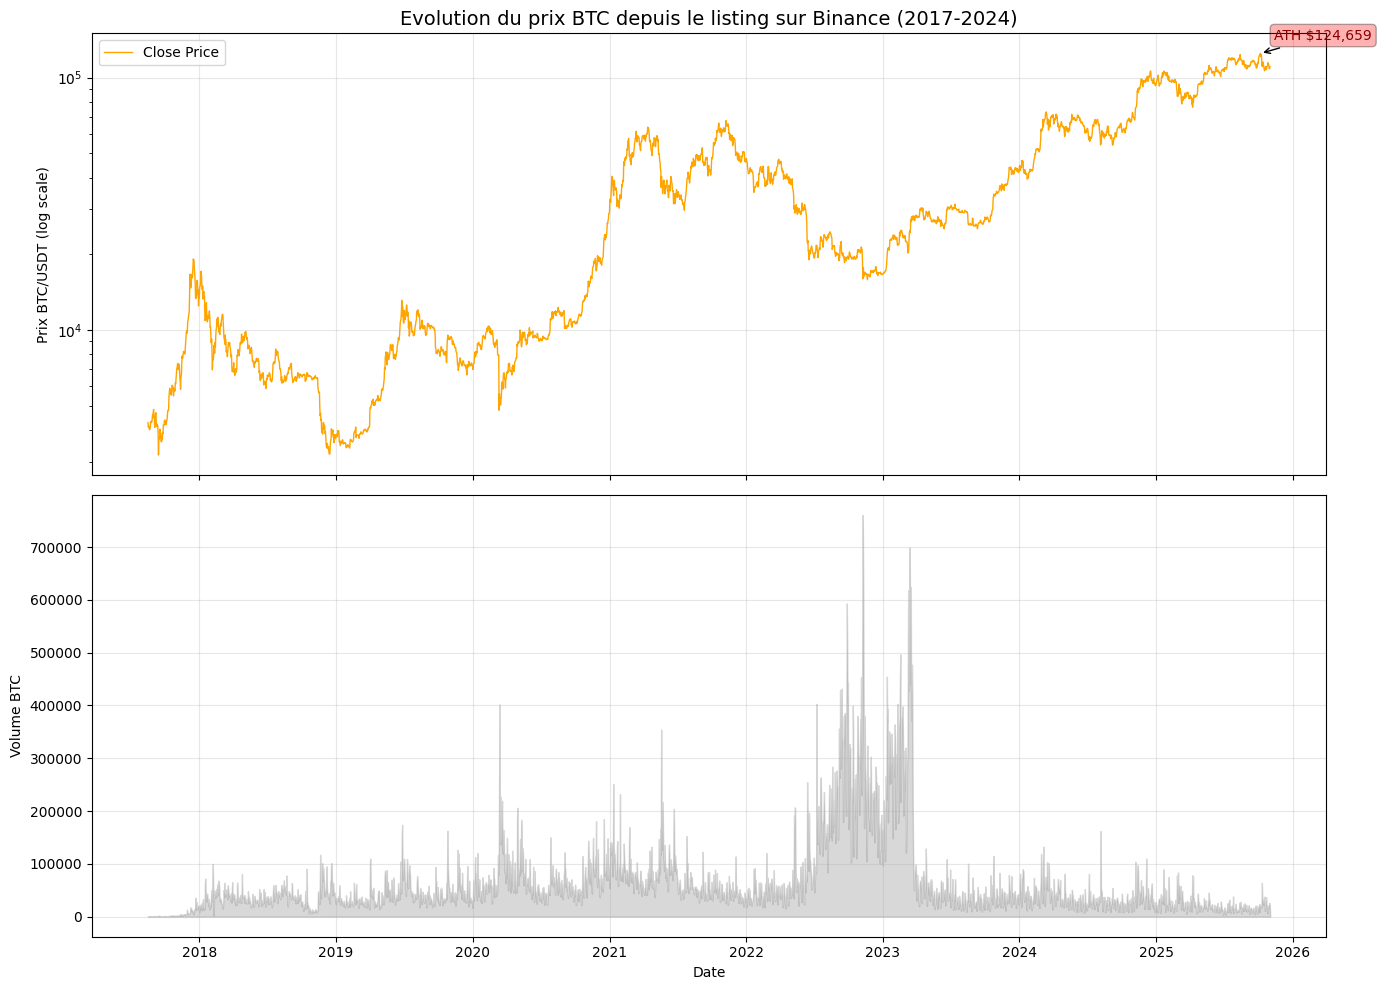

In [193]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(df_btc.index, df_btc['close'], linewidth=1, color='orange', label='Close Price')
ax1.set_yscale('log')
ax1.set_ylabel('Prix BTC/USDT (log scale)')
ax1.set_title('Evolution du prix BTC depuis le listing sur Binance (2017-2024)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

ath_date = df_btc['close'].idxmax()
ath_price = df_btc['close'].max()
ax1.annotate(f'ATH ${ath_price:,.0f}', 
             xy=(ath_date, ath_price), 
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
             fontsize=10, color='darkred')

ax2.fill_between(df_btc.index, df_btc['volume'], alpha=0.3, color='gray')
ax2.set_ylabel('Volume BTC')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Time-Series Momentum (TSM) de Pedersen



In [194]:
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-28 00:00:00+00:00,114107.650000,116086.000000,112211.000000,112898.450000,15523.422570
2025-10-29 00:00:00+00:00,112898.440000,113643.730000,109200.000000,110021.290000,21079.713760
2025-10-30 00:00:00+00:00,110021.300000,111592.000000,106304.340000,108322.880000,25988.828380


In [195]:
df_btc
df_btc.dropna(inplace=True)
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-28 00:00:00+00:00,114107.650000,116086.000000,112211.000000,112898.450000,15523.422570
2025-10-29 00:00:00+00:00,112898.440000,113643.730000,109200.000000,110021.290000,21079.713760
2025-10-30 00:00:00+00:00,110021.300000,111592.000000,106304.340000,108322.880000,25988.828380


Exponentially Weighted Moving Average
$$ \sigma_t^2 = (1 - \lambda) r_{t-1}^2 + \lambda \sigma_{t-1}^2 $$

In [196]:
lambda_vol = 0.9836  # EWMA centre-of-mass ≈ 60 jours
vol_floor = 0.15  # plancher de volatilité annualisée pour éviter l'effet levier excessif

returns = df_btc['close'].pct_change().fillna(0.0)

ewma_var = returns.pow(2).ewm(alpha=(1 - lambda_vol), adjust=False).mean()
ewma_sigma_daily = np.sqrt(ewma_var)
ewma_sigma_annual = (ewma_sigma_daily * np.sqrt(252.0)).clip(lower=vol_floor)

df_btc['return'] = returns
df_btc['ewma_vol_daily'] = ewma_sigma_daily
df_btc['ewma_vol_annual'] = ewma_sigma_annual
df_btc.tail()

,open,high,low,close,volume,return,ewma_vol_daily,ewma_vol_annual
timestamp,,,,,,,,
2025-10-28 00:00:00+00:00,114107.650000,116086.000000,112211.000000,112898.450000,15523.422570,-0.010597,0.018976,0.301233
2025-10-29 00:00:00+00:00,112898.440000,113643.730000,109200.000000,110021.290000,21079.713760,-0.025484,0.019101,0.303211
2025-10-30 00:00:00+00:00,110021.300000,111592.000000,106304.340000,108322.880000,25988.828380,-0.015437,0.019046,0.302348
2025-10-31 00:00:00+00:00,108322.870000,111190.000000,108275.280000,109608.010000,21518.204390,0.011864,0.018950,0.300827
2025-11-01 00:00:00+00:00,109608.010000,110564.490000,109394.810000,110174.440000,6911.569990,0.005168,0.018806,0.298535


Regression Analysis and trading strat

$$ \frac{r_t}{\sigma_{t-1}} = \alpha + \beta \frac{r_{t-h}}{\sigma_{t-h-1}} + \varepsilon_t $$


In [197]:
sigma = df_btc['ewma_vol_annual']
r = df_btc['return']

r_scaled = r / sigma.shift(1)
lag = 1
r_lagged_scaled = r.shift(lag) / sigma.shift(lag + 1)

$$ y = \alpha + \beta x + \varepsilon $$


In [198]:
def compute_tsm_signals(
    prices: pd.Series,
    lookback_months: int = 12,
    vol_lambda: float = 0.9836,
    target_vol: float = 0.25,
    vol_floor: float = 0.15,
    max_leverage: float = 3.0,
    signal_threshold: float = 0.02,
    transaction_cost_bps: float = 5.0,
    funding: Optional[pd.Series] = None,
) -> pd.DataFrame:
    prices = prices.dropna().sort_index()
    monthly_prices = prices.resample('M').last()
    daily_returns = prices.pct_change().dropna()

    ewma_var = daily_returns.pow(2).ewm(alpha=1 - vol_lambda, adjust=False).mean()
    ewma_vol_daily = np.sqrt(ewma_var)
    ewma_vol_annual = (ewma_vol_daily * np.sqrt(252.0)).clip(lower=vol_floor)

    df = pd.DataFrame(index=monthly_prices.index)
    df['close'] = monthly_prices
    df['asset_return'] = df['close'].pct_change().fillna(0.0)

    momentum_col = f'momentum_{lookback_months}m'
    df[momentum_col] = df['close'].pct_change(lookback_months)
    df['raw_signal'] = df[momentum_col]
    df['signal_direction'] = np.sign(df['raw_signal'])
    df.loc[df['raw_signal'].abs() < signal_threshold, 'signal_direction'] = 0.0
    df['signal'] = df['signal_direction'].shift(1).fillna(0.0)

    sigma_annual = ewma_vol_annual.resample('M').last().reindex(df.index)
    sigma_annual = sigma_annual.shift(1)
    sigma_annual = sigma_annual.fillna(method='ffill').fillna(method='bfill')
    sigma_annual = sigma_annual.clip(lower=vol_floor)
    df['sigma_annual'] = sigma_annual

    target_leverage = (target_vol / df['sigma_annual']).replace([np.inf, -np.inf], np.nan)
    df['position_unclipped'] = df['signal'] * target_leverage
    df['position'] = df['position_unclipped'].clip(lower=-max_leverage, upper=max_leverage).fillna(0.0)

    df['turnover'] = df['position'].diff().abs().fillna(df['position'].abs())
    cost_rate = transaction_cost_bps / 10000.0
    df['transaction_cost'] = df['turnover'] * cost_rate

    if funding is not None:
        funding_monthly = funding.resample('M').sum().reindex(df.index).fillna(0.0)
    else:
        funding_monthly = pd.Series(0.0, index=df.index)

    df['funding_pnl'] = funding_monthly * df['position']
    df['strategy_return_gross'] = df['position'] * df['asset_return']
    df['strategy_return_net'] = df['strategy_return_gross'] - df['transaction_cost'] + df['funding_pnl']
    df['strategy_equity'] = (1.0 + df['strategy_return_net']).cumprod()
    df['buy_hold_equity'] = (1.0 + df['asset_return']).cumprod()

    return df

signals_tsm = compute_tsm_signals(df_btc['close'])
signals_tsm[['close', 'position', 'strategy_return_net']].tail(20)

,close,position,strategy_return_net
timestamp,,,
2024-04-30 00:00:00+00:00,60672.000000,0.496247,-0.073904
2024-05-31 00:00:00+00:00,67540.010000,0.525361,0.059456
2024-06-30 00:00:00+00:00,62772.010000,0.541997,-0.038271
2024-07-31 00:00:00+00:00,64628.000000,0.625757,0.018460
2024-08-31 00:00:00+00:00,58973.990000,0.642360,-0.056205
2024-09-30 00:00:00+00:00,63327.590000,0.545669,0.040234
2024-10-31 00:00:00+00:00,70292.010000,0.599961,0.065953
2024-11-30 00:00:00+00:00,96407.990000,0.653447,0.242752
2024-12-31 00:00:00+00:00,93576.000000,0.566731,-0.016691


### Surface momentum (k, h)

Exploration de la signature de continuation : régression des rendements futurs (h mois) sur les rendements passés (k mois) pour k ∈ {3, 6, 9, 12} et h jusqu'à 18 mois.

In [199]:
def compute_momentum_surface(prices: pd.Series, k_values, h_values) -> pd.DataFrame:
    monthly_prices = prices.resample('M').last().dropna()
    results = []
    for k in k_values:
        past_return = monthly_prices.pct_change(k)
        for h in h_values:
            future_return = monthly_prices.shift(-h) / monthly_prices - 1.0
            df_reg = pd.DataFrame({'past': past_return, 'future': future_return}).dropna()
            if df_reg.empty:
                continue
            X = sm.add_constant(df_reg['past'])
            model = sm.OLS(df_reg['future'], X).fit(cov_type='HAC', cov_kwds={'maxlags': max(1, min(12, h))})
            results.append({
                'k_months': k,
                'h_months': h,
                'beta': model.params['past'],
                't_stat': model.tvalues['past'],
                'n_obs': int(model.nobs),
            })
    return pd.DataFrame(results).sort_values(['k_months', 'h_months'])

k_vals = [3, 6, 9, 12]
h_vals = [1, 3, 6, 9, 12, 15, 18]
momentum_surface_df = compute_momentum_surface(df_btc['close'], k_vals, h_vals)

# Matrices pour lecture rapide (β et t-stat)
beta_matrix = momentum_surface_df.pivot(index='k_months', columns='h_months', values='beta')
tstat_matrix = momentum_surface_df.pivot(index='k_months', columns='h_months', values='t_stat')

momentum_surface_df, beta_matrix, tstat_matrix

(                              k_months  h_months      beta    t_stat  n_obs
 typing.Literal[<no_default>]                                               
 0                                    3         1  0.042441  0.925588     96
 1                                    3         3  0.017013  0.134389     94
 2                                    3         6 -0.196795 -1.197180     91
 3                                    3         9 -0.181015 -0.994293     88
 4                                    3        12 -0.414798 -1.534489     85
 5                                    3        15 -0.674190 -1.922204     82
 6                                    3        18 -0.733364 -1.817867     79
 7                                    6         1 -0.005788 -0.197695     93
 8                                    6         3 -0.043181 -0.545559     91
 9                                    6         6 -0.110967 -1.114753     88
 10                                   6         9 -0.177029 -1.560744     85

### Régressions de validation façon papier

Les rendements normalisés sont régressés sur les signaux retardés pour confirmer la persistance jusqu'à 12 mois.

In [200]:
def tsm_validation_table(signals: pd.DataFrame, horizons, scaled: bool = True, max_hac_lag: int = 6) -> pd.DataFrame:
    df = signals[['asset_return', 'sigma_annual']].dropna()
    y = df['asset_return'] / df['sigma_annual']
    rows = []
    for h in horizons:
        if scaled:
            x_raw = df['asset_return'].shift(h) / df['sigma_annual'].shift(h)
            regressor_label = 'scaled'
        else:
            x_raw = np.sign(df['asset_return'].shift(h))
            regressor_label = 'sign'
        df_reg = pd.DataFrame({'y': y, 'x': x_raw}).dropna()
        if df_reg.empty:
            continue
        hac_lag = max(1, min(max_hac_lag, h))
        X = sm.add_constant(df_reg['x'])
        model = sm.OLS(df_reg['y'], X).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lag})
        rows.append({
            'h_months': h,
            'beta': model.params['x'],
            't_stat': model.tvalues['x'],
            'n_obs': int(model.nobs),
            'regressor': regressor_label,
        })
    return pd.DataFrame(rows).sort_values(['regressor', 'h_months'])

horizons = list(range(1, 19))
validation_scaled = tsm_validation_table(signals_tsm, horizons, scaled=True)
validation_sign = tsm_validation_table(signals_tsm, horizons, scaled=False)
validation_scaled, validation_sign

(    h_months      beta    t_stat  n_obs regressor
 0          1  0.223656  2.477576     99    scaled
 1          2  0.031801  0.381035     98    scaled
 2          3  0.004105  0.048781     97    scaled
 3          4 -0.022335 -0.262037     96    scaled
 4          5 -0.097599 -1.044691     95    scaled
 5          6 -0.131404 -1.082365     94    scaled
 6          7 -0.126089 -1.791527     93    scaled
 7          8  0.100963  1.325111     92    scaled
 8          9  0.006488  0.064757     91    scaled
 9         10 -0.071890 -1.092587     90    scaled
 10        11  0.019335  0.251903     89    scaled
 11        12 -0.109739 -1.274277     88    scaled
 12        13 -0.059622 -0.521940     87    scaled
 13        14 -0.070126 -0.904702     86    scaled
 14        15 -0.072691 -0.714838     85    scaled
 15        16 -0.139751 -1.659016     84    scaled
 16        17 -0.014297 -0.138083     83    scaled
 17        18  0.114780  0.629047     82    scaled,
     h_months      beta    t_s

### Convexité (profil straddle-like)

Régression des rendements de la stratégie sur le BTC et son carré pour mesurer la convexité (β₂).

In [201]:
def convexity_regression(signals: pd.DataFrame):
    df = signals[['strategy_return_net', 'asset_return']].dropna().copy()
    df['squared_return'] = df['asset_return'] ** 2
    X = sm.add_constant(df[['asset_return', 'squared_return']])
    model = sm.OLS(df['strategy_return_net'], X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    return model

convexity_model = convexity_regression(signals_tsm)
pd.Series({
    'alpha': convexity_model.params['const'],
    'beta_1': convexity_model.params['asset_return'],
    'beta_2': convexity_model.params['squared_return'],
    't_alpha': convexity_model.tvalues['const'],
    't_beta_1': convexity_model.tvalues['asset_return'],
    't_beta_2': convexity_model.tvalues['squared_return'],
    'r_squared': convexity_model.rsquared,
    'n_obs': int(convexity_model.nobs),
})

alpha         0.010865
beta_1        0.145831
beta_2       -0.128794
t_alpha       1.364456
t_beta_1      1.447972
t_beta_2     -0.387646
r_squared     0.075162
n_obs       100.000000
dtype: float64

In [202]:
def compute_metrics(prices: pd.Series, rsi_window: int = 14) -> pd.DataFrame:
    close = prices.dropna().copy()
    returns = close.pct_change().dropna()
    vol = returns.rolling(30).std() * np.sqrt(365)
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    roll_up = gain.ewm(alpha=1 / rsi_window, adjust=False).mean()
    roll_down = loss.ewm(alpha=1 / rsi_window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    out = pd.DataFrame({
        "close": close,
        "return": returns,
        "vol_30d": vol,
        f"rsi_{rsi_window}": rsi,
    })
    return out

metrics = compute_metrics(df_btc["close"]) 
metrics.tail()


,close,return,vol_30d,rsi_14
timestamp,,,,
2025-10-28 00:00:00+00:00,112898.450000,-0.010597,0.433949,50.482248
2025-10-29 00:00:00+00:00,110021.290000,-0.025484,0.437679,44.744889
2025-10-30 00:00:00+00:00,108322.880000,-0.015437,0.440553,41.729912
2025-10-31 00:00:00+00:00,109608.010000,0.011864,0.417739,44.762833
2025-11-01 00:00:00+00:00,110174.440000,0.005168,0.413245,46.094611


In [203]:
def performance_summary(returns: pd.Series, periods_per_year: int = 12) -> pd.Series:
    series = returns.dropna()
    if series.empty:
        return pd.Series(dtype=float)
    cumulative = (1.0 + series).cumprod()
    annual_return = cumulative.iloc[-1] ** (periods_per_year / len(series)) - 1.0
    annual_vol = series.std() * np.sqrt(periods_per_year)
    sharpe = annual_return / annual_vol if annual_vol > 0 else np.nan
    drawdown = cumulative / cumulative.cummax() - 1.0
    max_drawdown = drawdown.min()
    return pd.Series({
        "annual_return": annual_return,
        "annual_vol": annual_vol,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    })

performance_df = pd.DataFrame({
    "TSM": performance_summary(signals_tsm["strategy_return_net"]),
    "BuyHold": performance_summary(signals_tsm["asset_return"]),
})
performance_df

,TSM,BuyHold
annual_return,0.103577,0.459226
annual_vol,0.326339,0.713318
sharpe,0.317390,0.643789
max_drawdown,-0.544541,-0.749635


In [204]:
df_btc["close"]["2025-10-30 00:00:00+00:00"]

108322.88

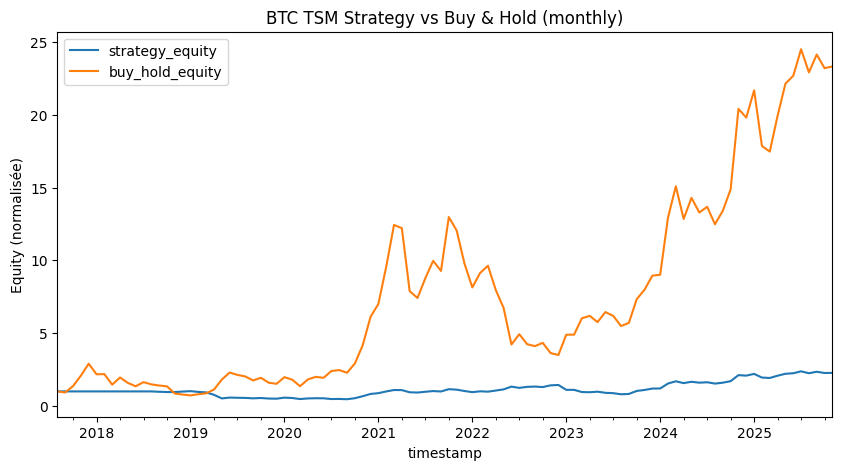

In [205]:
ax = signals_tsm[["strategy_equity", "buy_hold_equity"]].plot(
    figsize=(10, 5),
    title="BTC TSM Strategy vs Buy & Hold (monthly)"
)
ax.set_ylabel("Equity (normalisée)")  
plt.show()

### Walk-Forward Optimization (WFA)

Cette section réalise une optimisation walk-forward de la stratégie TSM en calibrant les hyperparamètres sur une fenêtre d’entraînement glissante, puis en évaluant en dehors de l’échantillon (OOS).


In [206]:
from itertools import product
from dataclasses import dataclass
from typing import Dict, List, Tuple


def compute_sharpe(returns: pd.Series, periods_per_year: int = 12) -> float:
    series = returns.dropna()
    if series.empty:
        return np.nan
    ann_ret = (1.0 + series).prod() ** (periods_per_year / len(series)) - 1.0
    ann_vol = series.std() * np.sqrt(periods_per_year)
    return float(ann_ret / ann_vol) if ann_vol > 0 else np.nan


@dataclass
class ParamSet:
    lookback_months: int
    signal_threshold: float
    target_vol: float
    vol_lambda: float
    max_leverage: float = 3.0
    transaction_cost_bps: float = 5.0

    def to_kwargs(self) -> Dict:
        return {
            "lookback_months": self.lookback_months,
            "signal_threshold": self.signal_threshold,
            "target_vol": self.target_vol,
            "vol_lambda": self.vol_lambda,
            "max_leverage": self.max_leverage,
            "transaction_cost_bps": self.transaction_cost_bps,
        }


def generate_param_grid() -> List[ParamSet]:
    grid = []
    for lb, thr, tv, vl in product([3, 6, 9, 12], [0.0, 0.01, 0.02], [0.20, 0.25], [0.97, 0.9836]):
        grid.append(ParamSet(lookback_months=lb, signal_threshold=thr, target_vol=tv, vol_lambda=vl))
    return grid


def _compute_signals_with_context(prices: pd.Series, test_start: pd.Timestamp, test_end: pd.Timestamp, params: ParamSet) -> pd.DataFrame:
    # Utilise train + test pour bien former les signaux au bord
    context_start = prices.index.min()
    prices_context = prices.loc[context_start:test_end]
    sig = compute_tsm_signals(prices_context, **params.to_kwargs())
    return sig.loc[test_start:test_end]


def grid_search_on_train(prices: pd.Series, train_start: pd.Timestamp, train_end: pd.Timestamp, param_grid: List[ParamSet]) -> Tuple[ParamSet, pd.DataFrame]:
    records = []
    # Compute signals sur la fenêtre d'entraînement uniquement (pas besoin de contexte au-delà)
    for p in param_grid:
        sig = compute_tsm_signals(prices.loc[train_start:train_end], **p.to_kwargs())
        sharpe = compute_sharpe(sig["strategy_return_net"]) if not sig.empty else np.nan
        records.append({
            "params": p,
            "lookback_months": p.lookback_months,
            "signal_threshold": p.signal_threshold,
            "target_vol": p.target_vol,
            "vol_lambda": p.vol_lambda,
            "sharpe_train": sharpe,
            "n_train": int(len(sig)),
        })
    df = pd.DataFrame(records).sort_values("sharpe_train", ascending=False)
    best = df.iloc[0]["params"] if not df.empty else None
    return best, df


def walk_forward(prices: pd.Series, train_years: int = 3, test_months: int = 6, param_grid: List[ParamSet] = None):
    if param_grid is None:
        param_grid = generate_param_grid()

    start_date = prices.index.min()
    end_date = prices.index.max()

    oos_returns = []
    segment_rows = []
    test_cursor = start_date + pd.DateOffset(years=train_years)

    while test_cursor < end_date:
        train_start = test_cursor - pd.DateOffset(years=train_years)
        train_end = test_cursor - pd.DateOffset(days=1)
        test_start = test_cursor
        test_end = min(test_start + pd.DateOffset(months=test_months) - pd.DateOffset(days=1), end_date)

        # Calibrage sur train
        best_params, train_table = grid_search_on_train(prices, train_start, train_end, param_grid)
        if best_params is None:
            break

        # Evaluation OOS
        sig_test = _compute_signals_with_context(prices, test_start, test_end, best_params)
        if sig_test.empty:
            test_cursor = test_end + pd.DateOffset(days=1)
            continue

        sharpe_oos = compute_sharpe(sig_test["strategy_return_net"]) if not sig_test.empty else np.nan
        oos_returns.append(sig_test["strategy_return_net"])

        segment_rows.append({
            "train_start": train_start,
            "train_end": train_end,
            "test_start": test_start,
            "test_end": test_end,
            "best_lb": best_params.lookback_months,
            "best_thr": best_params.signal_threshold,
            "best_tv": best_params.target_vol,
            "best_vl": best_params.vol_lambda,
            "sharpe_train": float(train_table.iloc[0]["sharpe_train"]) if not train_table.empty else np.nan,
            "sharpe_oos": sharpe_oos,
            "n_oos": int(len(sig_test)),
        })

        test_cursor = test_end + pd.DateOffset(days=1)

    oos_returns = pd.concat(oos_returns).sort_index() if oos_returns else pd.Series(dtype=float)
    segments = pd.DataFrame(segment_rows)
    return segments, oos_returns


# Exécution WFA (par défaut: 3 ans train / 6 mois test)
param_grid = generate_param_grid()
segments_wfa, oos_returns_wfa = walk_forward(df_btc["close"], train_years=3, test_months=6, param_grid=param_grid)

oos_equity_wfa = (1.0 + oos_returns_wfa).cumprod()
summary_wfa = performance_summary(oos_returns_wfa)
segments_wfa, summary_wfa, oos_equity_wfa.tail(3)


(                 train_start                 train_end   
 0  2017-08-17 00:00:00+00:00 2020-08-16 00:00:00+00:00  \
 1  2018-02-17 00:00:00+00:00 2021-02-16 00:00:00+00:00   
 2  2018-08-17 00:00:00+00:00 2021-08-16 00:00:00+00:00   
 3  2019-02-17 00:00:00+00:00 2022-02-16 00:00:00+00:00   
 4  2019-08-17 00:00:00+00:00 2022-08-16 00:00:00+00:00   
 5  2020-02-17 00:00:00+00:00 2023-02-16 00:00:00+00:00   
 6  2020-08-17 00:00:00+00:00 2023-08-16 00:00:00+00:00   
 7  2021-02-17 00:00:00+00:00 2024-02-16 00:00:00+00:00   
 8  2021-08-17 00:00:00+00:00 2024-08-16 00:00:00+00:00   
 9  2022-02-17 00:00:00+00:00 2025-02-16 00:00:00+00:00   
 10 2022-08-17 00:00:00+00:00 2025-08-16 00:00:00+00:00   
 
                   test_start                  test_end  best_lb  best_thr   
 0  2020-08-17 00:00:00+00:00 2021-02-16 00:00:00+00:00        3  0.000000  \
 1  2021-02-17 00:00:00+00:00 2021-08-16 00:00:00+00:00        3  0.000000   
 2  2021-08-17 00:00:00+00:00 2022-02-16 00:00:00+00:00 

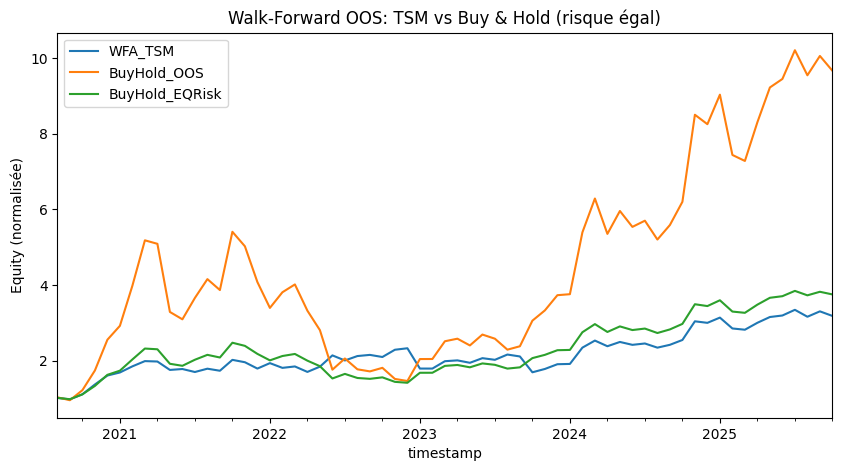

(                WFA_TSM  BuyHold_OOS  BuyHold_EQRisk
 annual_return  0.246622     0.540621        0.286314
 annual_vol     0.301941     0.640887        0.301941
 sharpe         0.816790     0.843552        0.948246
 max_drawdown  -0.273371    -0.730139       -0.428711,
 {'wfa_ann_vol': 0.3019405678701037,
  'bh_ann_vol': 0.6408866141121448,
  'scale_bh_to_wfa': 0.47112946537102895})

In [207]:
# Visualisation et comparaison OOS à risque égal (WFA vs Buy & Hold)
monthly_close = df_btc["close"].resample("M").last()
# Rendements Buy & Hold alignés sur l'index OOS WFA
bh_returns_oos = monthly_close.pct_change().reindex(oos_returns_wfa.index)

# Mise à l'échelle du Buy & Hold pour égaliser la volatilité annualisée à celle de WFA
common_idx = oos_returns_wfa.dropna().index.intersection(bh_returns_oos.dropna().index)
wfa_common = oos_returns_wfa.reindex(common_idx)
bh_common = bh_returns_oos.reindex(common_idx)
wfa_vol_ann = wfa_common.std() * np.sqrt(12)
bh_vol_ann = bh_common.std() * np.sqrt(12)
scale_bh = float(wfa_vol_ann / bh_vol_ann) if bh_vol_ann > 0 else np.nan
bh_returns_oos_eq = bh_returns_oos * scale_bh

# Courbes d'equity
ax = pd.DataFrame({
    "WFA_TSM": (1.0 + oos_returns_wfa).cumprod(),
    "BuyHold_OOS": (1.0 + bh_returns_oos).cumprod(),
    "BuyHold_EQRisk": (1.0 + bh_returns_oos_eq).cumprod(),
}).plot(figsize=(10, 5), title="Walk-Forward OOS: TSM vs Buy & Hold (risque égal)")
ax.set_ylabel("Equity (normalisée)")
plt.show()

# Tableau de performances (ajoute la version risque égal)
perf_oos_compare = pd.DataFrame({
    "WFA_TSM": performance_summary(oos_returns_wfa),
    "BuyHold_OOS": performance_summary(bh_returns_oos),
    "BuyHold_EQRisk": performance_summary(bh_returns_oos_eq),
})
# Info de mise à l'échelle pour référence
risk_match_info = {
    "wfa_ann_vol": wfa_vol_ann,
    "bh_ann_vol": bh_vol_ann,
    "scale_bh_to_wfa": scale_bh,
}
perf_oos_compare, risk_match_info


### Validation croisée en série temporelle (grille d’hyperparamètres)

Validation par fenêtres temporelles expansives (anchored expanding) sur index mensuel, objectif: Sharpe moyen OOS sur les folds.


In [208]:
def build_time_series_splits(monthly_index: pd.DatetimeIndex, n_splits: int = 5, test_size_months: int = 12, min_train_months: int = 36):
    monthly_index = pd.DatetimeIndex(sorted(monthly_index.unique()))
    first_date = monthly_index.min()
    last_date = monthly_index.max()

    # Point de départ du premier test pour garantir un train minimal
    start_test = first_date + pd.DateOffset(months=min_train_months)
    splits = []
    for k in range(n_splits):
        test_start = start_test + pd.DateOffset(months=k * test_size_months)
        test_end = test_start + pd.DateOffset(months=test_size_months) - pd.DateOffset(days=1)
        if test_end > last_date:
            break
        train_start = first_date
        train_end = test_start - pd.DateOffset(days=1)
        splits.append((train_start, train_end, test_start, test_end))
    return splits


def ts_cv_grid_search(prices: pd.Series, param_grid: List[ParamSet], n_splits: int = 5, test_size_months: int = 12, min_train_months: int = 36) -> pd.DataFrame:
    monthly_index = prices.resample('M').last().dropna().index
    splits = build_time_series_splits(monthly_index, n_splits=n_splits, test_size_months=test_size_months, min_train_months=min_train_months)
    rows = []
    for p in param_grid:
        sharpe_folds = []
        for (train_start, train_end, test_start, test_end) in splits:
            # contexte: train + test pour former les signaux à la frontière
            sig_ctxt = compute_tsm_signals(prices.loc[train_start:test_end], **p.to_kwargs())
            ret_oos = sig_ctxt.loc[test_start:test_end]["strategy_return_net"] if not sig_ctxt.empty else pd.Series(dtype=float)
            sharpe_folds.append(compute_sharpe(ret_oos))
        rows.append({
            "lookback_months": p.lookback_months,
            "signal_threshold": p.signal_threshold,
            "target_vol": p.target_vol,
            "vol_lambda": p.vol_lambda,
            "mean_sharpe": np.nanmean(sharpe_folds),
            "std_sharpe": np.nanstd(sharpe_folds),
            "n_folds": len(sharpe_folds),
        })
    return pd.DataFrame(rows).sort_values(["mean_sharpe", "std_sharpe"], ascending=[False, True])


# Lancement CV avec même grille que WFA
cv_results = ts_cv_grid_search(df_btc["close"], param_grid, n_splits=6, test_size_months=12, min_train_months=36)
cv_results.head(10)


,lookback_months,signal_threshold,target_vol,vol_lambda,mean_sharpe,std_sharpe,n_folds
39,12,0.000000,0.250000,0.983600,1.256775,1.250503,5
43,12,0.010000,0.250000,0.983600,1.256775,1.250503,5
47,12,0.020000,0.250000,0.983600,1.256775,1.250503,5
27,9,0.000000,0.250000,0.983600,1.247408,1.185342,5
31,9,0.010000,0.250000,0.983600,1.247408,1.185342,5
35,9,0.020000,0.250000,0.983600,1.247408,1.185342,5
37,12,0.000000,0.200000,0.983600,1.212765,1.210530,5
41,12,0.010000,0.200000,0.983600,1.212765,1.210530,5
45,12,0.020000,0.200000,0.983600,1.212765,1.210530,5
38,12,0.000000,0.250000,0.970000,1.212074,1.204438,5


### Bootstrap par blocs (robustesse OOS)

Bootstrap par blocs mobiles des rendements mensuels OOS (WFA) pour estimer la distribution du Sharpe, CAGR et max drawdown.


In [209]:
def moving_block_bootstrap(returns: pd.Series, block_length: int = 6, n_bootstrap: int = 2000, random_state: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)
    r = returns.dropna().values
    T = len(r)
    if T == 0:
        return pd.DataFrame()
    n_blocks = int(np.ceil(T / block_length))
    max_start = max(1, T - block_length)

    sims = np.empty((n_bootstrap, T))
    for b in range(n_bootstrap):
        sample = []
        while len(sample) < T:
            start = int(rng.integers(0, max_start))
            block = r[start:start + block_length]
            sample.extend(block)
        sims[b, :] = np.array(sample[:T])
    idx = returns.dropna().index
    return pd.DataFrame(sims, columns=idx)


# Bootstrap sur les rendements OOS (WFA)
bs = moving_block_bootstrap(oos_returns_wfa, block_length=6, n_bootstrap=2000, random_state=123)

sharpes = []
ann_rets = []
max_dds = []
for i in range(len(bs)):
    s = pd.Series(bs.iloc[i, :])
    perf = performance_summary(s)
    sharpes.append(perf.get("sharpe", np.nan))
    ann_rets.append(perf.get("annual_return", np.nan))
    max_dds.append(perf.get("max_drawdown", np.nan))

bootstrap_summary = pd.DataFrame({
    "sharpe": sharpes,
    "annual_return": ann_rets,
    "max_drawdown": max_dds,
})

quantiles = bootstrap_summary.quantile([0.05, 0.5, 0.95])
quantiles


,sharpe,annual_return,max_drawdown
0.050000,0.121328,0.034493,-0.422986
0.500000,0.784308,0.232355,-0.275315
0.950000,1.689163,0.528737,-0.180462
